# Initial inspection of data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

In [3]:
path = './summer_2022_project/'
audio_path = path + '/audio'

total_dataset = set(os.listdir(audio_path))
df = pd.read_csv(path+'development.csv', index_col='filename', dtype={'emotion':'string'}) # set string as type
df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
training_set = set(df.index)
evaluation_set = total_dataset-training_set

df.head()

,emotion,filename
0,Disgusted,0.wav
1,Fearful,1.wav
2,Neutral,2.wav
3,Happy,3.wav
4,Angry,4.wav


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9597 entries, 0 to 9596
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   emotion   9597 non-null   string
 1   filename  9597 non-null   string
dtypes: string(2)
memory usage: 150.1 KB


In [5]:
labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels
labels_dict

{'Disgusted': 0,
 'Fearful': 1,
 'Neutral': 2,
 'Happy': 3,
 'Angry': 4,
 'Sad': 5,
 'Suprised': 6}

In [6]:
df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


In [7]:
emotion_sr = df.emotion.value_counts()
emotion_sr.index
print('label\tnumber of samples')
emotion_sr

label	number of samples


Happy        1625
Angry        1625
Sad          1625
Fearful      1535
Disgusted    1397
Neutral      1346
Suprised      444
Name: emotion, dtype: Int64

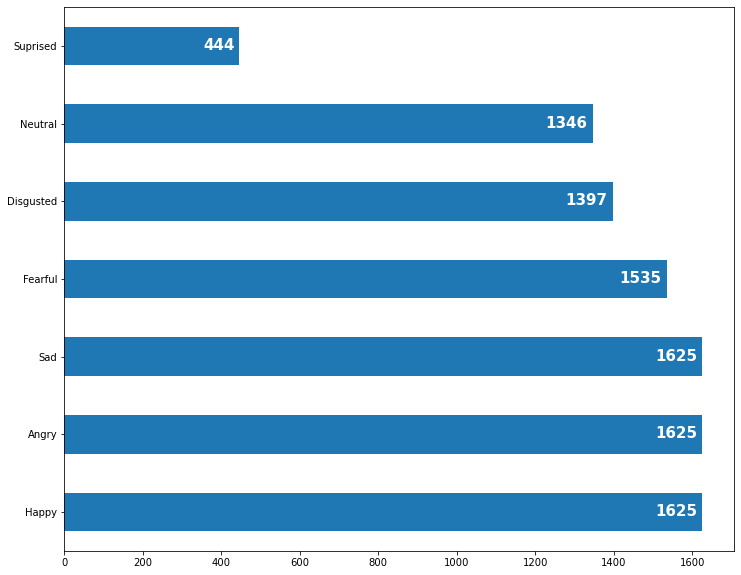

In [8]:
emotion_val_series = df.emotion.value_counts()
emotion_val_series.plot(kind='barh', figsize=(12,10), color='tab:blue')
for i, v in enumerate(emotion_val_series):
    if i == len(emotion_val_series)-1:
        plt.text(v - 90, i -0.05, str(v), color='white', fontweight='bold', fontsize=15)
    else:
        plt.text(v - 120, i -0.05, str(v), color='white', fontweight='bold', fontsize=15)

We have 7 different class labels for a total of 9597 training samples (out of 12798 of the overall dataset):
- Surprised (444)
- Neutral   (1346)
- Disgusted (1397)
- Fearful   (1535)
- Sad       (1625)
- Angry     (1625)
- Happy     (1625)

Most of them are balanced but "Surprised" has way less samples. Hence, we need to deal with it.

# Data visualization

In [9]:
from scipy.io.wavfile import read
from scipy import signal

d = dict()
for filename in df.filename:
    sample_rate, samples = read(audio_path+f'/{filename}')
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    d[(int)(filename.split('.')[0])] = {'samples':samples, 'sample_rate':sample_rate, 'time_length':len(samples)/sample_rate, 'frequencies':frequencies, 'spectrogram':spectrogram}  

Text(0, 0.5, 'Frequency (Hz)')

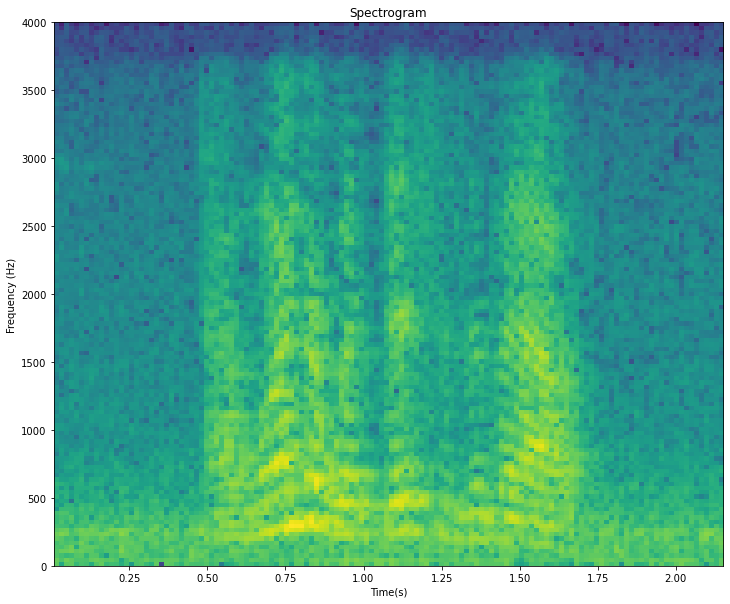

In [10]:
samples, sample_rate = d[0]['samples'], d[0]['sample_rate']
plt.figure(figsize=(12,10))
plt.specgram(x = samples, Fs = sample_rate, cmap='viridis') #x = array of samples, Fs = sample rate
plt.title('Spectrogram')
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Amplitude')

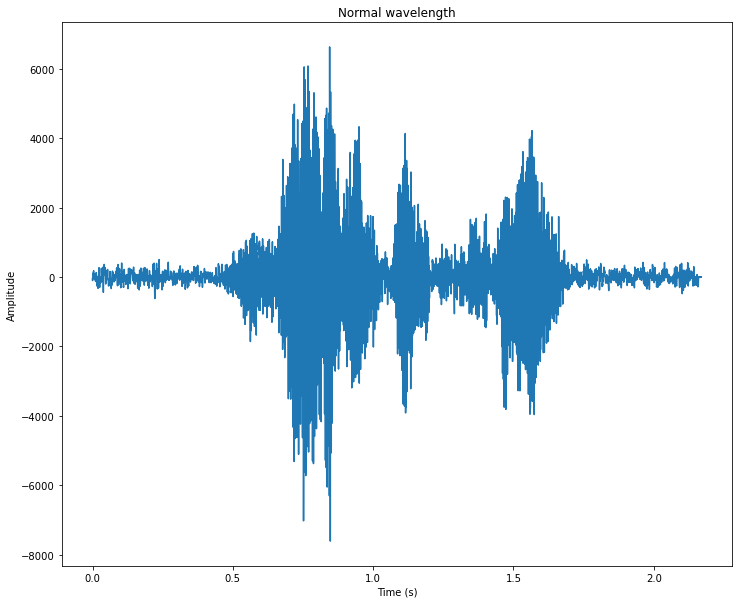

In [11]:
time_axis = np.linspace(0, len(samples)/sample_rate, num=len(samples))
plt.figure(figsize=(12,10))
plt.plot(time_axis, samples, color='tab:blue')
plt.title('Normal wavelength')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [12]:
samples, samples.max(), samples.min()

(array([ -46, -103,  -88, ...,    0,    0,    0], dtype=int16), 6632, -7613)

|WAV format        |Min   |Max   |NumPy dtype|
|------------------|------|------|-----------|
|16-bit integer PCM|-32768|+32767|int16      |

In [13]:
temp_df = pd.DataFrame.from_dict(d).T
temp_df['emotion'] = df.emotion
temp_df['encoded_emotion'] = df.encoded_emotion
temp_df = temp_df.astype({'time_length':float})
temp_df.head()

,samples,sample_rate,time_length,frequencies,spectrogram,emotion,encoded_emotion
0,"[-46, -103, -88, -91, -70, -55, -39, -15, 20, ...",8000,2.169000,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[3.3801324, 12.052663, 0.16704863, 0.397491, ...",Disgusted,0
1,"[117, 301, 296, 302, 275, 264, 244, 213, 161, ...",8000,2.669500,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[0.47520238, 13.986137, 2.8514621, 17.818419,...",Fearful,1
2,"[-1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -...",8000,3.837375,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[0.0001733794, 3.5454577e-05, 9.601911e-06, 7...",Neutral,2
3,"[-1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, 0, ...",8000,3.403625,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[0.0003778362, 0.00011231503, 6.29442e-05, 0....",Happy,3
4,"[77, 208, 212, 207, 193, 212, 213, 205, 210, 1...",8000,2.869750,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[4.822137, 6.9771757, 0.14937395, 1.0288435, ...",Angry,4


In [14]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9597 entries, 0 to 9596
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   samples          9597 non-null   object 
 1   sample_rate      9597 non-null   object 
 2   time_length      9597 non-null   float64
 3   frequencies      9597 non-null   object 
 4   spectrogram      9597 non-null   object 
 5   emotion          9597 non-null   string 
 6   encoded_emotion  9597 non-null   int64  
dtypes: float64(1), int64(1), object(4), string(1)
memory usage: 599.8+ KB


<AxesSubplot:xlabel='emotion', ylabel='time_length'>

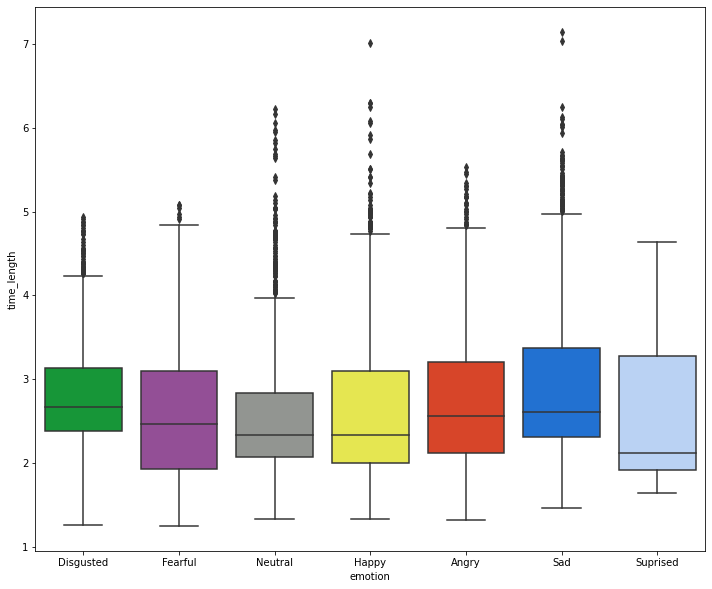

In [15]:
colors = ['kelly green',     # Disgusted
          'medium purple',    # Fearful
          'grey',             # Neutral
          'lemon yellow',     # Happy
          'vermillion',       # Angry
          'cerulean blue',    # Sad
          'powder blue']      # Surprised
     
my_palette = sns.xkcd_palette(colors)

plt.figure(figsize=(12,10))
sns.boxplot(x='emotion', y='time_length', data=temp_df, palette=my_palette)


<AxesSubplot:xlabel='emotion', ylabel='time_length'>

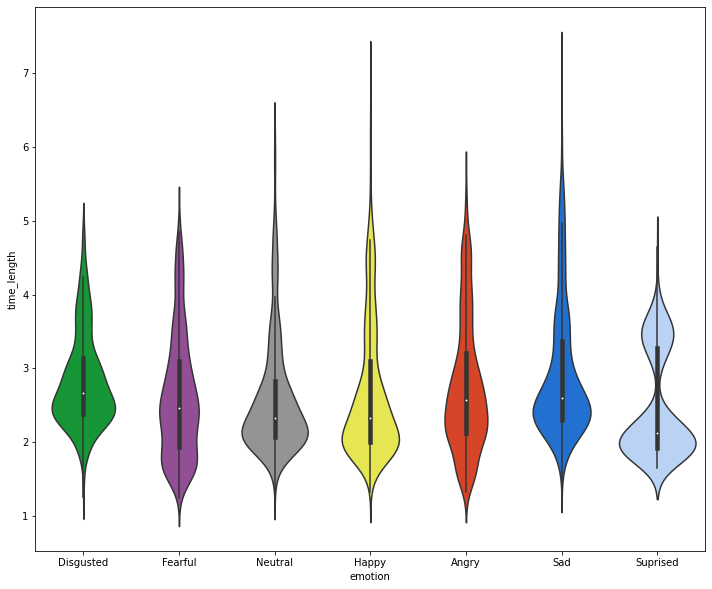

In [16]:
plt.figure(figsize=(12,10))
sns.violinplot(x='emotion', y='time_length', data=temp_df, palette=my_palette)

Colors found at: https://xkcd.com/color/rgb/

Custom categorical palettes using dictionary gave me errors. Found this alternative route.

In [17]:
plt.figure(figsize=(12,10))
temp_df.groupby('emotion')['time_length'].describe()

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
Angry,1625.0,2.758348,0.889712,1.326625,2.127500,2.569375,3.203250,5.527875
Disgusted,1397.0,2.830282,0.638181,1.268000,2.382000,2.669375,3.136500,4.938500
Fearful,1535.0,2.615037,0.833615,1.254125,1.935375,2.469250,3.103250,5.071750
Happy,1625.0,2.669564,0.906174,1.334750,2.002125,2.335750,3.103250,7.012625
Neutral,1346.0,2.602233,0.785585,1.334750,2.070938,2.335750,2.836250,6.226500
Sad,1625.0,2.941256,0.900640,1.468250,2.310125,2.607125,3.375375,7.138750
Suprised,444.0,2.468897,0.704724,1.650125,1.927719,2.127813,3.278344,4.638125


<Figure size 864x720 with 0 Axes>

Happy and Sad are the ones with maximum length. We can think that if someone is happy, he wants to talk. Same thing concerning sad.

<AxesSubplot:xlabel='time_length', ylabel='Count'>

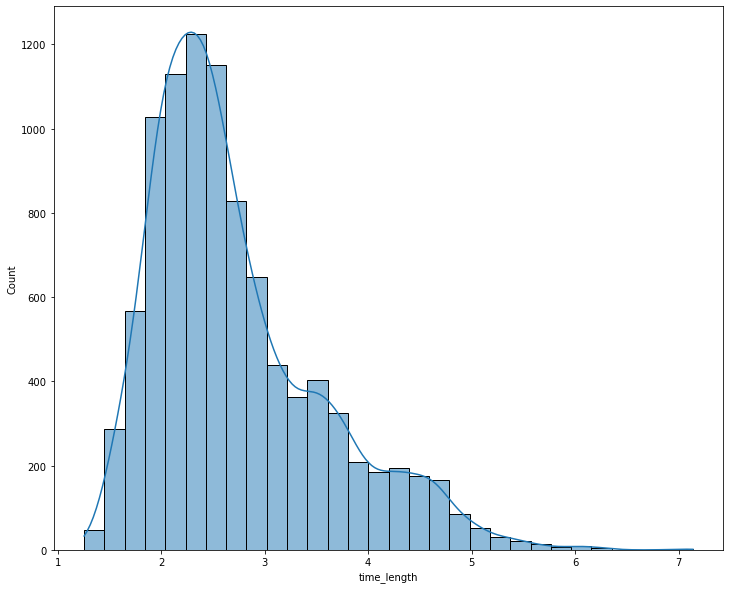

In [18]:
plt.figure(figsize=(12,10))
sns.histplot(temp_df.time_length, bins=30, kde=True, color='tab:blue')

In [19]:
mask = temp_df.time_length > 6
temp_df[mask][['time_length','emotion']]

,time_length,emotion
434,6.039500,Sad
494,6.242250,Happy
1921,6.032750,Sad
1985,6.129625,Sad
2039,6.289375,Happy
2391,6.058750,Happy
2669,6.156625,Neutral
2751,6.289375,Happy
3824,6.226500,Neutral
4672,7.012625,Happy


By manual inspection, they don't have silences.

In [20]:
print(temp_df[mask].emotion.value_counts())

Sad        8
Happy      6
Neutral    3
Name: emotion, dtype: Int64


In [21]:
for i in range(3,8):
    print(f'{i} seconds threshold')
    mask = temp_df.time_length > i
    print(temp_df[mask].emotion.value_counts())

3 seconds threshold
Sad          541
Angry        511
Disgusted    444
Happy        431
Fearful      424
Neutral      290
Suprised     137
Name: emotion, dtype: Int64
4 seconds threshold
Sad          215
Angry        207
Happy        187
Fearful      137
Neutral      106
Disgusted     92
Suprised       3
Name: emotion, dtype: Int64
5 seconds threshold
Sad        74
Happy      27
Neutral    21
Angry      17
Fearful     3
Name: emotion, dtype: Int64
6 seconds threshold
Sad        8
Happy      6
Neutral    3
Name: emotion, dtype: Int64
7 seconds threshold
Sad      2
Happy    1
Name: emotion, dtype: Int64


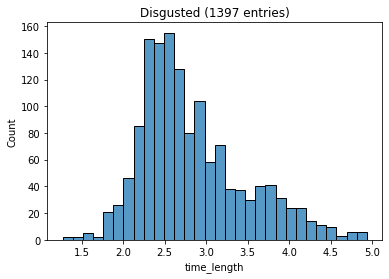

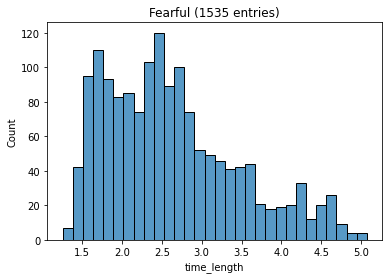

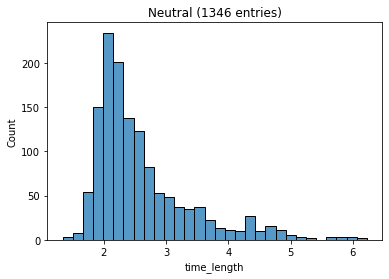

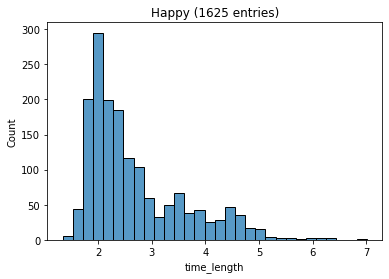

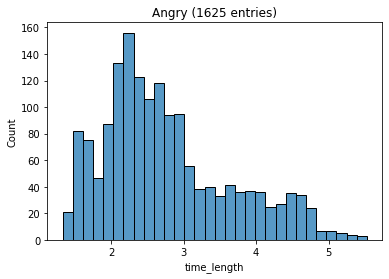

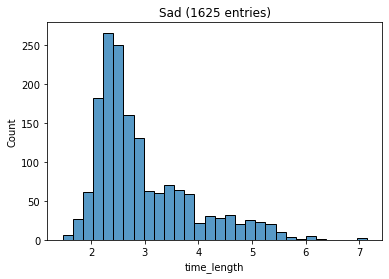

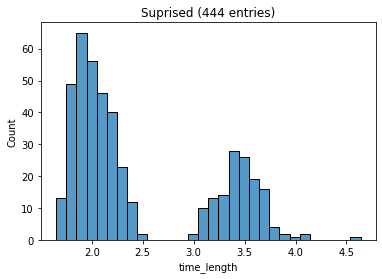

In [22]:
for i in range(len(labels)):
    mask = temp_df.emotion == labels[i]
    sns.histplot(temp_df[mask].time_length, bins=30, color='tab:blue')
    plt.title(labels[i] + f' ({len(temp_df[mask])} entries)')
    plt.show()

Seguono tutti una gamma distribution, possibile che in surprised manchino dei sample nel range 2.5-3?


# Feature extraction

In [23]:
d[0].keys()

dict_keys(['samples', 'sample_rate', 'time_length', 'frequencies', 'spectrogram'])

In [24]:
def divide_matrix(ary:np.array, num_columns:int, num_rows:int):    
    
    if (num_columns > ary.shape[1] or num_rows > ary.shape[0]):
        return 'Error, the requested number of columns or rows exceed dimensions!'
    
    first = np.array_split(ary, num_rows, axis=0) # num rows
    second = []
    for array in first:
        second.append(np.array_split(array, num_columns, axis=1)) # num columns
    flattened_list = flatten(second)
    return flattened_list

def flatten(l:list):
    flattened_list = []
    for item in l:
        for i in item:
            flattened_list.append(i)
    return flattened_list
    
def compute_feature(list_of_arrays:list) -> dict:
    d = dict()
    for id in range(len(list_of_arrays)):
        d[f'{id}_mean_feature'] = np.mean(list_of_arrays[id])
        d[f'{id}_std_feature'] = np.std(list_of_arrays[id])
    return d

def create_dict_dataset(path:str, is_eval:bool=False) -> dict:
    """
    function used to read the dataset. It creates a dictionary in
    the following form:
    id: {label, frequencies, times, spectrogram}.
    If is_eval == True, no label.

    Args:
        path (str): path used to read the dataset
        is_eval (bool, optional): boolean flag to set to True
        if the dataset you want to read is the evaluation one.
        Defaults to False.

    Returns:
        dict: dataset in dictionary form
    """
    all_samples = os.listdir(path)
    d = dict()
    for sample in all_samples:
        if is_eval:
            id = int(sample.split('.')[0])
        else:
            id = int(sample.split('_')[0])
        sample_rate, samples = read(path + sample)
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
        if is_eval:
            d_temp = {'frequencies': frequencies,
                      'times': times,
                      'spectrogram': spectrogram} 
        else:
            d_temp = {'label': int(sample.split('_')[1][:-4]), # till -4 since it has the .wav extension
                    'frequencies': frequencies,
                      'times': times,
                      'spectrogram': spectrogram} 
        d[id] = d_temp 
    return d

In [25]:
temp_df.head()

,samples,sample_rate,time_length,frequencies,spectrogram,emotion,encoded_emotion
0,"[-46, -103, -88, -91, -70, -55, -39, -15, 20, ...",8000,2.169000,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[3.3801324, 12.052663, 0.16704863, 0.397491, ...",Disgusted,0
1,"[117, 301, 296, 302, 275, 264, 244, 213, 161, ...",8000,2.669500,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[0.47520238, 13.986137, 2.8514621, 17.818419,...",Fearful,1
2,"[-1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -...",8000,3.837375,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[0.0001733794, 3.5454577e-05, 9.601911e-06, 7...",Neutral,2
3,"[-1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, 0, ...",8000,3.403625,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[0.0003778362, 0.00011231503, 6.29442e-05, 0....",Happy,3
4,"[77, 208, 212, 207, 193, 212, 213, 205, 210, 1...",8000,2.869750,"[0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5...","[[4.822137, 6.9771757, 0.14937395, 1.0288435, ...",Angry,4


In [26]:
shrunk_df = temp_df[['spectrogram', 'encoded_emotion']]
shrunk_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596],
           dtype='int64', length=9597)

In [27]:
shrunk_df.head()

,spectrogram,encoded_emotion
0,"[[3.3801324, 12.052663, 0.16704863, 0.397491, ...",0
1,"[[0.47520238, 13.986137, 2.8514621, 17.818419,...",1
2,"[[0.0001733794, 3.5454577e-05, 9.601911e-06, 7...",2
3,"[[0.0003778362, 0.00011231503, 6.29442e-05, 0....",3
4,"[[4.822137, 6.9771757, 0.14937395, 1.0288435, ...",4


---------------
prove

In [41]:
# ho più 'colonne' che valori. 
# Ho un rettangolo.
# Voglio provare a mantenere lo stesso rapporto tra numero colonne e numero righe
# Questo è però indicativo di un solo sample. 
# Forse mi conviene fare una media delle righe e delle colonne degli spettrogrammi
ratio = spectrogram.shape[0]/spectrogram.shape[1]


In [42]:
a = shrunk_df.loc[0]['spectrogram']
n = 5
b = divide_matrix(a, num_rows=n, num_columns=n*ratio)
len(b[0]) == len(b[-1]) # not always true

False

In [43]:
c = dict()
c[0] =  compute_feature(b)
cacca_df = pd.DataFrame.from_dict(c).T
cacca_df

,0_mean_feature,0_std_feature,10_mean_feature,10_std_feature,11_mean_feature,11_std_feature,12_mean_feature,12_std_feature,13_mean_feature,13_std_feature,...,5_mean_feature,5_std_feature,6_mean_feature,6_std_feature,7_mean_feature,7_std_feature,8_mean_feature,8_std_feature,9_mean_feature,9_std_feature
0,29.383663,63.51403,28.703026,90.561371,122.246475,679.788269,547.270203,4128.12207,0.082377,0.132282,...,236.692505,584.722107,25.477348,67.48336,0.063999,0.069886,25.764494,102.989449,315.2052,916.397278


In [61]:
dictionary = dict()
for row in tqdm(shrunk_df.index):
    # z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n*ratio)) # with ratio
    z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n))
    z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
    dictionary[row] = z
    
new_df = pd.DataFrame.from_dict(dictionary).T
new_df

100%|██████████| 9597/9597 [00:15<00:00, 637.90it/s]


In [63]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

np.random.seed(0) #to make experiments reproducible

X_train, X_test, y_train, y_test = train_test_split(new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]], test_size=.2)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
print('Fitting...')
#rf = RandomForestClassifier().fit(X_train, y_train)
print('Predicting...')
preds = rf.predict(X_test)
f1_score(y_test, preds, average='macro')

Fitting...
Predicting...


0.5651521612665257

------------
# OVERSAMPLING

In [28]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

np.random.seed(0) #to make experiments reproducible


In [81]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE

np.random.seed(0) #to make experiments reproducible

smote = SMOTE(random_state=42)
blsmote = BorderlineSMOTE(random_state=42)
svmsmote = SVMSMOTE(random_state=42)
adasyn = ADASYN(random_state=42, sampling_strategy='minority')


#print(ksmote.cluster_balance_threshold)
#over_samplers = [smote, blsmote, svmsmote, adasyn, ksmote]
over_samplers = [smote, blsmote, svmsmote, adasyn]

for sm in over_samplers:
    print(sm)
    X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
    X_res, y_res = sm.fit_resample(X,y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    print(sm, score)

SMOTE(random_state=42)
Fitting...
Predicting...
SMOTE(random_state=42) 0.6271223329528377
BorderlineSMOTE(random_state=42)
Fitting...
Predicting...
BorderlineSMOTE(random_state=42) 0.6269937102259139
SVMSMOTE(random_state=42)
Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6405991338429862
ADASYN(random_state=42, sampling_strategy='minority')
Fitting...
Predicting...
ADASYN(random_state=42, sampling_strategy='minority') 0.6041570654316654


random_state = 42

|Model          |F1 macro   |Random state   |Sampling strategy|
|---------------|-----------|---------------|-----------------|
|SMOTE          |0.62712    |42             |auto             |
|BorderlineSMOTE|0.62699    |42             |auto             |
|SVMSMOTE       |0.6406     |42             |auto             |
|ADASYN         |0.6042     |42             |minority         |

In [65]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

np.random.seed(0) #to make experiments reproducible

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

#rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
print('Fitting...')
rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
print('Predicting...')
preds = rf.predict(X_test)
f1_score(y_test, preds, average='macro')

Fitting...
Predicting...


0.6399871679137196

# Choice of n (no ratio)

100%|██████████| 9597/9597 [00:05<00:00, 1664.49it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.4912382939567546


100%|██████████| 9597/9597 [00:11<00:00, 853.60it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6231015218490865


100%|██████████| 9597/9597 [00:19<00:00, 495.22it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6401842304003212


100%|██████████| 9597/9597 [00:30<00:00, 309.87it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6442178275192486


100%|██████████| 9597/9597 [00:48<00:00, 195.93it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6586590672251484


100%|██████████| 9597/9597 [01:05<00:00, 147.23it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6693744733417247


100%|██████████| 9597/9597 [01:27<00:00, 109.87it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6618251252140112


100%|██████████| 9597/9597 [01:54<00:00, 84.06it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6569554211395364


100%|██████████| 9597/9597 [02:19<00:00, 68.91it/s]
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.654884464998913


100%|██████████| 9597/9597 [03:13<00:00, 49.57it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6558135353635192


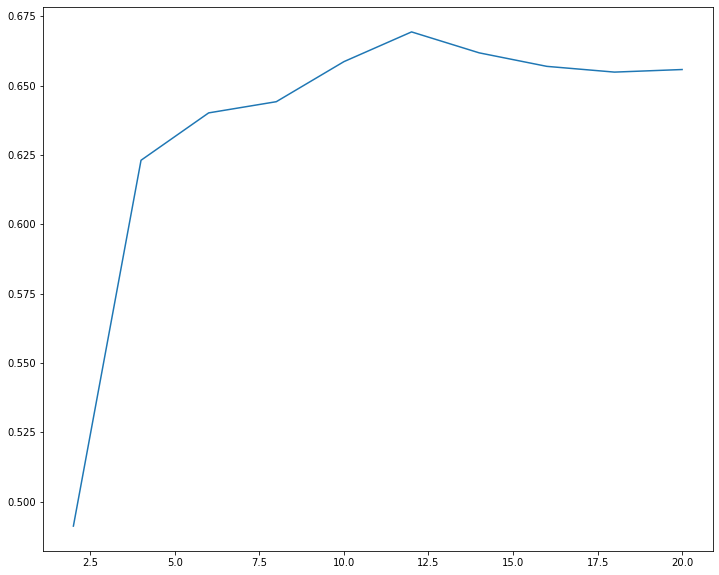

In [87]:
ns = list(range(2,22,2))
scores = []
for n in ns:
    dictionary = dict()
    for row in tqdm(shrunk_df.index):
        # z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n*ratio)) # with ratio
        z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n))
        z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
        dictionary[row] = z
        
    new_df = pd.DataFrame.from_dict(dictionary).T
    
    np.random.seed(0) #to make experiments reproducible


    svmsmote = SVMSMOTE(random_state=42)

    X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
    X_res, y_res = svmsmote.fit_resample(X,y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores.append(score)
    print(svmsmote, score)
    
plt.figure(figsize=(12,10))
plt.plot(ns, scores, label='F1 macro')

In [88]:
print(scores)
print(ns)

[0.4912382939567546, 0.6231015218490865, 0.6401842304003212, 0.6442178275192486, 0.6586590672251484, 0.6693744733417247, 0.6618251252140112, 0.6569554211395364, 0.654884464998913, 0.6558135353635192]
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


In [91]:
idx = np.argmax(scores)
ns[idx]

12

n: 10


100%|██████████| 9597/9597 [00:43<00:00, 219.69it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6586590672251484
n: 11


100%|██████████| 9597/9597 [00:52<00:00, 184.48it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6513656126798544
n: 12


100%|██████████| 9597/9597 [01:00<00:00, 157.76it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6693744733417247
n: 13


100%|██████████| 9597/9597 [01:13<00:00, 130.44it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6627617336284641
n: 14


100%|██████████| 9597/9597 [01:28<00:00, 108.86it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6618251252140112


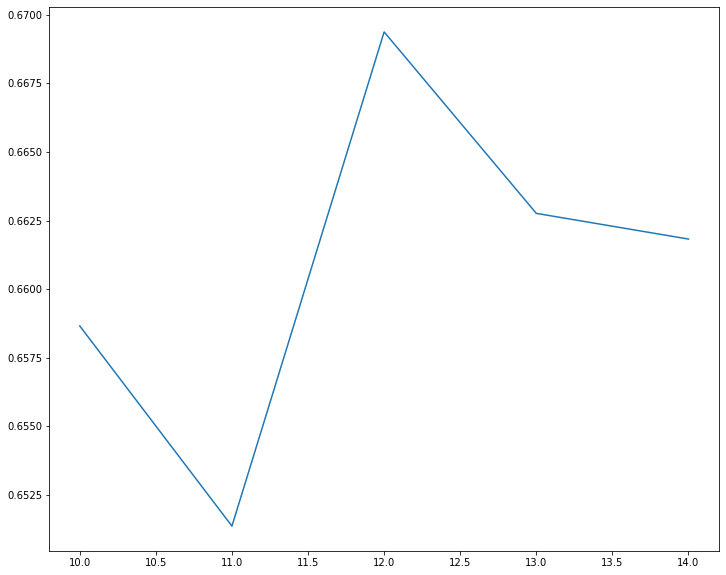

In [29]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import f1_score



ns = [10,11,12,13,14]
scores = []
for n in ns:
    print('n:', n)
    dictionary = dict()
    for row in tqdm(shrunk_df.index):
        # z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n*ratio)) # with ratio
        z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n))
        z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
        dictionary[row] = z
        
    new_df = pd.DataFrame.from_dict(dictionary).T
    
    np.random.seed(0) #to make experiments reproducible


    svmsmote = SVMSMOTE(random_state=42)

    X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
    X_res, y_res = svmsmote.fit_resample(X,y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores.append(score)
    print(svmsmote, score)
    
plt.figure(figsize=(12,10))
plt.plot(ns, scores, label='F1 macro')

n = 12

# Choice of n using ratio (and seeing if this improves results)

In [33]:
shrunk_df.spectrogram.map(lambda x: (x.shape[0],x.shape[1]))
row_mean_shape = spectrogram.shape[0] # any spectrogram is ok since they have the same shape[0]

In [34]:
column_mean_shape = shrunk_df.spectrogram.map(lambda x: x.shape[1]).mean() # mean number of columns (time dimension)

In [35]:
ratio_rows_columns = row_mean_shape/column_mean_shape 

In [36]:
ratio_rows_columns 

1.3334033416589388

In [39]:
round(n*ratio_rows_columns)

19

n_rows: 2
n_columns: 3


100%|██████████| 9597/9597 [00:06<00:00, 1547.78it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.56988846997342
---------
n_rows: 4
n_columns: 5


100%|██████████| 9597/9597 [00:12<00:00, 757.26it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6347832319861043
---------
n_rows: 6
n_columns: 8


100%|██████████| 9597/9597 [00:22<00:00, 420.86it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6469532504667039
---------
n_rows: 8
n_columns: 11


100%|██████████| 9597/9597 [00:39<00:00, 242.16it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.658220820420042
---------
n_rows: 10
n_columns: 13


100%|██████████| 9597/9597 [00:56<00:00, 169.58it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6630939096973315
---------
n_rows: 12
n_columns: 16


100%|██████████| 9597/9597 [01:29<00:00, 107.05it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6592045602103448
---------
n_rows: 14
n_columns: 19


100%|██████████| 9597/9597 [02:01<00:00, 79.03it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6663751107548033
---------
n_rows: 16
n_columns: 21


100%|██████████| 9597/9597 [02:19<00:00, 69.01it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6455261827034425
---------
n_rows: 18
n_columns: 24


100%|██████████| 9597/9597 [03:03<00:00, 52.32it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6567670895663614
---------
n_rows: 20
n_columns: 27


100%|██████████| 9597/9597 [03:49<00:00, 41.87it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6591547694226103
---------


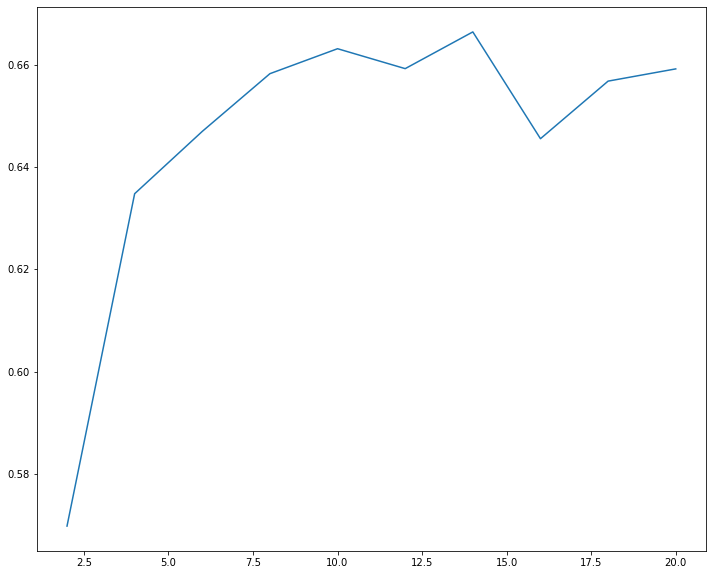

In [41]:
ns = list(range(2,22,2))
scores = []
for n in ns:
    print('n_rows:',n)
    print('n_columns:', round(n*ratio_rows_columns))
    dictionary = dict()
    for row in tqdm(shrunk_df.index):
        # z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n*ratio)) # with ratio
        z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=round(n*ratio_rows_columns)))
        z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
        dictionary[row] = z
        
    new_df = pd.DataFrame.from_dict(dictionary).T
    
    np.random.seed(0) #to make experiments reproducible


    svmsmote = SVMSMOTE(random_state=42)

    X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
    X_res, y_res = svmsmote.fit_resample(X,y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores.append(score)
    print(svmsmote, score)
    print('---------')
plt.figure(figsize=(12,10))
plt.plot(ns, scores, label='F1 macro')

----------
try to keep n_rows fixed to 12 and tune n_columns

n_rows: 12
n_columns: 2


100%|██████████| 9597/9597 [00:16<00:00, 598.64it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6213896118652759
---------
n_rows: 12
n_columns: 4


100%|██████████| 9597/9597 [00:24<00:00, 386.08it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6449480512774619
---------
n_rows: 12
n_columns: 6


100%|██████████| 9597/9597 [00:35<00:00, 270.24it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6626204262867369
---------
n_rows: 12
n_columns: 8


100%|██████████| 9597/9597 [00:46<00:00, 208.05it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6612620468235911
---------
n_rows: 12
n_columns: 10


100%|██████████| 9597/9597 [00:55<00:00, 173.71it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.670094204597392
---------
n_rows: 12
n_columns: 12


100%|██████████| 9597/9597 [01:06<00:00, 144.83it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6693744733417247
---------
n_rows: 12
n_columns: 14


100%|██████████| 9597/9597 [01:17<00:00, 123.85it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6605858456896044
---------
n_rows: 12
n_columns: 16


100%|██████████| 9597/9597 [01:28<00:00, 108.51it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6592045602103448
---------
n_rows: 12
n_columns: 18


100%|██████████| 9597/9597 [01:32<00:00, 103.70it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6517397027932625
---------
n_rows: 12
n_columns: 20


100%|██████████| 9597/9597 [01:41<00:00, 94.73it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.66579149204816
---------


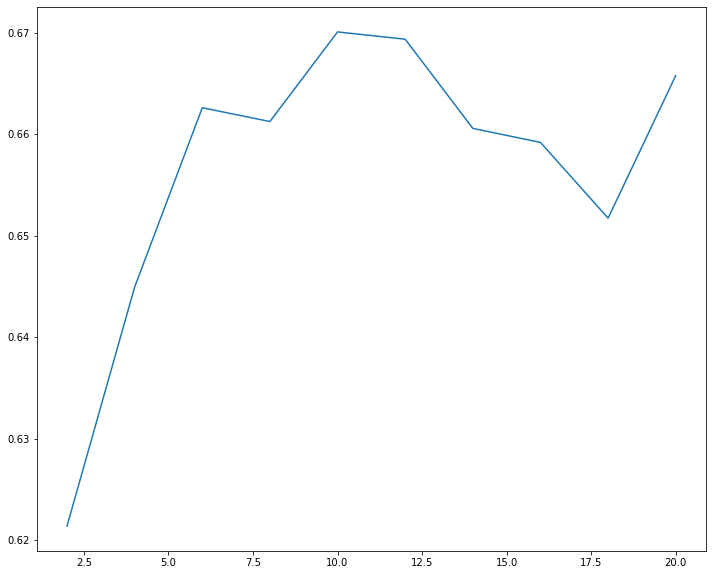

In [29]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import f1_score

ns = list(range(2,22,2))
scores = []
for n in ns:
    print('n_rows:',12)
    print('n_columns:', n)
    dictionary = dict()
    for row in tqdm(shrunk_df.index):
        # z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n*ratio)) # with ratio
        z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=12, num_columns=n))
        z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
        dictionary[row] = z
        
    new_df = pd.DataFrame.from_dict(dictionary).T
    
    np.random.seed(0) #to make experiments reproducible


    svmsmote = SVMSMOTE(random_state=42)

    X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
    X_res, y_res = svmsmote.fit_resample(X,y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores.append(score)
    print(svmsmote, score)
    print('---------')
plt.figure(figsize=(12,10))
plt.plot(ns, scores, label='F1 macro')

n_rows: 12
n_columns: 6


100%|██████████| 9597/9597 [00:36<00:00, 264.77it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6626204262867369
---------
n_rows: 12
n_columns: 7


100%|██████████| 9597/9597 [00:38<00:00, 247.00it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6565646189354476
---------
n_rows: 12
n_columns: 8


100%|██████████| 9597/9597 [00:47<00:00, 202.40it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6612620468235911
---------
n_rows: 12
n_columns: 9


100%|██████████| 9597/9597 [00:52<00:00, 181.29it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6643977302689266
---------
n_rows: 12
n_columns: 10


100%|██████████| 9597/9597 [00:55<00:00, 174.31it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.670094204597392
---------
n_rows: 12
n_columns: 11


100%|██████████| 9597/9597 [00:59<00:00, 161.42it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6638803884730098
---------
n_rows: 12
n_columns: 12


100%|██████████| 9597/9597 [01:05<00:00, 145.98it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6693744733417247
---------
n_rows: 12
n_columns: 13


100%|██████████| 9597/9597 [01:12<00:00, 133.05it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6580045050631218
---------
n_rows: 12
n_columns: 14


100%|██████████| 9597/9597 [01:16<00:00, 125.28it/s]


Fitting...
Predicting...
SVMSMOTE(random_state=42) 0.6605858456896044
---------


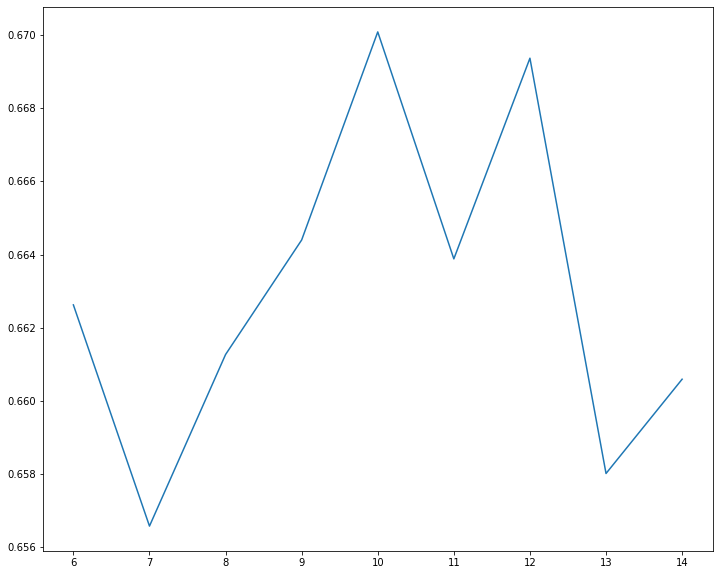

In [30]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import f1_score

ns = [6,7,8,9,10,11,12,13,14]
scores = []
for n in ns:
    print('n_rows:',12)
    print('n_columns:', n)
    dictionary = dict()
    for row in tqdm(shrunk_df.index):
        # z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=n, num_columns=n*ratio)) # with ratio
        z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=12, num_columns=n))
        z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
        dictionary[row] = z
        
    new_df = pd.DataFrame.from_dict(dictionary).T
    
    np.random.seed(0) #to make experiments reproducible


    svmsmote = SVMSMOTE(random_state=42)

    X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
    X_res, y_res = svmsmote.fit_resample(X,y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

    y_train = y_train.astype(int)
    y_test = y_test.astype(int)

    #rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
    print('Fitting...')
    rf = RandomForestClassifier().fit(X_train, y_train) # plain rf
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    scores.append(score)
    print(svmsmote, score)
    print('---------')
plt.figure(figsize=(12,10))
plt.plot(ns, scores, label='F1 macro')

best:
- n_rows = 12, 
- n_cols = 10

# random forest hyper parameters tuning wth gridsearch



In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import f1_score

In [31]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import f1_score


dictionary = dict()
for row in tqdm(shrunk_df.index):
    z = compute_feature(divide_matrix(shrunk_df.loc[row].spectrogram, num_rows=12, num_columns=10))
    z['encoded_emotion'] = shrunk_df.loc[row].encoded_emotion
    dictionary[row] = z
    
new_df = pd.DataFrame.from_dict(dictionary).T

np.random.seed(0) #to make experiments reproducible


svmsmote = SVMSMOTE(random_state=42)

X, y = new_df[new_df.columns[:-1]], new_df[new_df.columns[-1]]
X_res, y_res = svmsmote.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)


100%|██████████| 9597/9597 [01:04<00:00, 148.94it/s]


In [36]:
param_grid = {'n_estimators' : [10,20,50,100,150,300],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [10,20,30,None],
              'max_features': ['sqrt', 'log2', None]}

clfs = []
for configuration in tqdm(ParameterGrid(param_grid)):
    print('Fitting...')
    rf = RandomForestClassifier(**configuration).fit(X_train, y_train)
    print('Predicting...')
    preds = rf.predict(X_test)
    score = f1_score(y_test, preds, average='macro')
    clfs.append((rf, score))
    print(rf, score)
    print('---------')
    

  0%|          | 0/216 [00:00<?, ?it/s]

Fitting...


  0%|          | 1/216 [00:00<02:48,  1.27it/s]

Predicting...
RandomForestClassifier(max_depth=10, n_estimators=10) 0.5722473791749938
---------
Fitting...


  1%|          | 2/216 [00:02<04:36,  1.29s/it]

Predicting...
RandomForestClassifier(max_depth=10, n_estimators=20) 0.6346609545227576
---------
Fitting...


  1%|▏         | 3/216 [00:05<08:12,  2.31s/it]

Predicting...
RandomForestClassifier(max_depth=10, n_estimators=50) 0.6249339454350838
---------
Fitting...


  2%|▏         | 4/216 [00:12<14:36,  4.13s/it]

Predicting...
RandomForestClassifier(max_depth=10) 0.6307233336034984
---------
Fitting...


  2%|▏         | 5/216 [00:23<23:04,  6.56s/it]

Predicting...
RandomForestClassifier(max_depth=10, n_estimators=150) 0.6286117654840989
---------
Fitting...


  3%|▎         | 6/216 [00:44<40:01, 11.44s/it]

Predicting...
RandomForestClassifier(max_depth=10, n_estimators=300) 0.6316974798178698
---------
Fitting...


  3%|▎         | 7/216 [00:45<27:13,  7.82s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=10) 0.5682797941306764
---------
Fitting...


  4%|▎         | 8/216 [00:45<19:14,  5.55s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=20) 0.6129550012618509
---------
Fitting...


  4%|▍         | 9/216 [00:47<15:04,  4.37s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=50) 0.6232600357010052
---------
Fitting...


  5%|▍         | 10/216 [00:51<14:13,  4.14s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features='log2') 0.6235135065573526
---------
Fitting...


  5%|▌         | 11/216 [00:56<15:04,  4.41s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=150) 0.6255926852360997
---------
Fitting...


  6%|▌         | 12/216 [01:06<20:49,  6.13s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=300) 0.6258311305514003
---------
Fitting...


  6%|▌         | 13/216 [01:16<25:01,  7.40s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features=None, n_estimators=10) 0.5976305642657335
---------
Fitting...


  6%|▋         | 14/216 [01:36<38:07, 11.32s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features=None, n_estimators=20) 0.6104040480911179
---------
Fitting...


  7%|▋         | 15/216 [02:27<1:18:01, 23.29s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features=None, n_estimators=50) 0.6188011889775021
---------
Fitting...


  7%|▋         | 16/216 [04:09<2:36:39, 47.00s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features=None) 0.6266505418304353
---------
Fitting...


  8%|▊         | 17/216 [06:42<4:21:23, 78.81s/it]

Predicting...
RandomForestClassifier(max_depth=10, max_features=None, n_estimators=150) 0.6252880668532992
---------
Fitting...
Predicting...


  8%|▊         | 18/216 [12:22<8:38:47, 157.21s/it]

RandomForestClassifier(max_depth=10, max_features=None, n_estimators=300) 0.6301961510200048
---------
Fitting...


  9%|▉         | 19/216 [12:24<6:02:40, 110.46s/it]

Predicting...
RandomForestClassifier(max_depth=20, n_estimators=10) 0.6057724317834224
---------
Fitting...


  9%|▉         | 20/216 [12:26<4:15:14, 78.13s/it] 

Predicting...
RandomForestClassifier(max_depth=20, n_estimators=20) 0.6222559571387911
---------
Fitting...


 10%|▉         | 21/216 [12:33<3:04:23, 56.74s/it]

Predicting...
RandomForestClassifier(max_depth=20, n_estimators=50) 0.6514159269548134
---------
Fitting...


 10%|█         | 22/216 [12:47<2:22:12, 43.98s/it]

Predicting...
RandomForestClassifier(max_depth=20) 0.6531757387756869
---------
Fitting...


 11%|█         | 23/216 [13:09<1:59:46, 37.23s/it]

Predicting...
RandomForestClassifier(max_depth=20, n_estimators=150) 0.6674447163482883
---------
Fitting...
Predicting...


 11%|█         | 24/216 [13:50<2:02:56, 38.42s/it]

RandomForestClassifier(max_depth=20, n_estimators=300) 0.6640762782372756
---------
Fitting...


 12%|█▏        | 25/216 [13:51<1:26:18, 27.11s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=10) 0.5875776312867788
---------
Fitting...


 12%|█▏        | 26/216 [13:52<1:01:22, 19.38s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=20) 0.6261658472400561
---------
Fitting...


 12%|█▎        | 27/216 [13:56<46:05, 14.63s/it]  

Predicting...
RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=50) 0.6513623205978722
---------
Fitting...


 13%|█▎        | 28/216 [14:02<38:20, 12.24s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features='log2') 0.6530201206170047
---------
Fitting...
Predicting...


 13%|█▎        | 29/216 [14:14<37:12, 11.94s/it]

RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=150) 0.6618527129761077
---------
Fitting...
Predicting...


 14%|█▍        | 30/216 [14:35<46:07, 14.88s/it]

RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300) 0.6622045346343672
---------
Fitting...


 14%|█▍        | 31/216 [14:56<50:51, 16.50s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features=None, n_estimators=10) 0.6067463981988289
---------
Fitting...


 15%|█▍        | 32/216 [15:35<1:11:48, 23.41s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features=None, n_estimators=20) 0.6360303724138859
---------
Fitting...


 15%|█▌        | 33/216 [17:17<2:22:44, 46.80s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features=None, n_estimators=50) 0.6522777362918247
---------
Fitting...


 16%|█▌        | 34/216 [20:45<4:48:46, 95.20s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features=None) 0.6535691247602132
---------
Fitting...


 16%|█▌        | 35/216 [25:54<8:00:48, 159.39s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features=None, n_estimators=150) 0.6552201120172655
---------
Fitting...


 17%|█▋        | 36/216 [34:22<13:12:03, 264.02s/it]

Predicting...
RandomForestClassifier(max_depth=20, max_features=None, n_estimators=300) 0.6560689272613063
---------
Fitting...


 17%|█▋        | 37/216 [34:23<9:12:10, 185.09s/it] 

Predicting...
RandomForestClassifier(max_depth=30, n_estimators=10) 0.6064638065646575
---------
Fitting...


 18%|█▊        | 38/216 [34:25<6:25:58, 130.11s/it]

Predicting...
RandomForestClassifier(max_depth=30, n_estimators=20) 0.632406414973208
---------
Fitting...


 18%|█▊        | 39/216 [34:29<4:32:40, 92.43s/it] 

Predicting...
RandomForestClassifier(max_depth=30, n_estimators=50) 0.6469402589300197
---------
Fitting...


 19%|█▊        | 40/216 [34:38<3:17:40, 67.39s/it]

Predicting...
RandomForestClassifier(max_depth=30) 0.6653169413451833
---------
Fitting...


 19%|█▉        | 41/216 [34:52<2:29:14, 51.17s/it]

Predicting...
RandomForestClassifier(max_depth=30, n_estimators=150) 0.6685451668749648
---------
Fitting...


 19%|█▉        | 42/216 [35:18<2:07:00, 43.79s/it]

Predicting...
RandomForestClassifier(max_depth=30, n_estimators=300) 0.6622257521725553
---------
Fitting...


 20%|█▉        | 43/216 [35:19<1:28:48, 30.80s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=10) 0.5992023522220853
---------
Fitting...


 20%|██        | 44/216 [35:20<1:02:36, 21.84s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=20) 0.6220829377336127
---------
Fitting...


 21%|██        | 45/216 [35:22<45:29, 15.96s/it]  

Predicting...
RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=50) 0.646719078639225
---------
Fitting...


 21%|██▏       | 46/216 [35:26<35:25, 12.50s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features='log2') 0.6515937782731749
---------
Fitting...


 22%|██▏       | 47/216 [35:33<30:19, 10.76s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=150) 0.6664935107130343
---------
Fitting...


 22%|██▏       | 48/216 [35:46<32:17, 11.53s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features='log2', n_estimators=300) 0.6652967039751634
---------
Fitting...


 23%|██▎       | 49/216 [36:00<33:51, 12.17s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features=None, n_estimators=10) 0.6202073978199679
---------
Fitting...


 23%|██▎       | 50/216 [36:27<46:14, 16.72s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features=None, n_estimators=20) 0.6353810145540203
---------
Fitting...


 24%|██▎       | 51/216 [37:35<1:27:59, 32.00s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features=None, n_estimators=50) 0.6496789526847632
---------
Fitting...


 24%|██▍       | 52/216 [39:51<2:52:54, 63.26s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features=None) 0.6485690615253167
---------
Fitting...
Predicting...


 25%|██▍       | 53/216 [44:01<5:24:15, 119.36s/it]

RandomForestClassifier(max_depth=30, max_features=None, n_estimators=150) 0.6601710038379768
---------
Fitting...


 25%|██▌       | 54/216 [52:27<10:35:25, 235.34s/it]

Predicting...
RandomForestClassifier(max_depth=30, max_features=None, n_estimators=300) 0.6616515253611182
---------
Fitting...


 25%|██▌       | 55/216 [52:28<7:22:46, 165.01s/it] 

Predicting...
RandomForestClassifier(n_estimators=10) 0.606116780884065
---------
Fitting...


 26%|██▌       | 56/216 [52:30<5:09:27, 116.05s/it]

Predicting...
RandomForestClassifier(n_estimators=20) 0.6280930749968051
---------
Fitting...


 26%|██▋       | 57/216 [52:35<3:38:54, 82.61s/it] 

Predicting...
RandomForestClassifier(n_estimators=50) 0.646328629485227
---------
Fitting...


 27%|██▋       | 58/216 [52:44<2:39:20, 60.51s/it]

Predicting...
RandomForestClassifier() 0.6544490057672471
---------
Fitting...


 27%|██▋       | 59/216 [52:57<2:01:18, 46.36s/it]

Predicting...
RandomForestClassifier(n_estimators=150) 0.6707640757712261
---------
Fitting...


 28%|██▊       | 60/216 [53:23<1:45:06, 40.43s/it]

Predicting...
RandomForestClassifier(n_estimators=300) 0.6725438865177358
---------
Fitting...


 28%|██▊       | 61/216 [53:24<1:13:28, 28.44s/it]

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=10) 0.5892482013485214
---------
Fitting...


 29%|██▊       | 62/216 [53:25<51:49, 20.19s/it]  

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=20) 0.6260802666297393
---------
Fitting...


 29%|██▉       | 63/216 [53:27<37:48, 14.83s/it]

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=50) 0.6428996884590291
---------
Fitting...


 30%|██▉       | 64/216 [53:32<29:41, 11.72s/it]

Predicting...
RandomForestClassifier(max_features='log2') 0.6613699047684355
---------
Fitting...


 30%|███       | 65/216 [53:38<25:42, 10.21s/it]

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=150) 0.662267613786945
---------
Fitting...


 31%|███       | 66/216 [53:52<27:51, 11.14s/it]

Predicting...
RandomForestClassifier(max_features='log2', n_estimators=300) 0.6645684443799743
---------
Fitting...


 31%|███       | 67/216 [54:05<29:31, 11.89s/it]

Predicting...
RandomForestClassifier(max_features=None, n_estimators=10) 0.6006813958075311
---------
Fitting...


 31%|███▏      | 68/216 [54:32<40:26, 16.40s/it]

Predicting...
RandomForestClassifier(max_features=None, n_estimators=20) 0.6355656260160537
---------
Fitting...


 32%|███▏      | 69/216 [55:40<1:18:13, 31.93s/it]

Predicting...
RandomForestClassifier(max_features=None, n_estimators=50) 0.6438593186052018
---------
Fitting...


 32%|███▏      | 70/216 [57:56<2:33:33, 63.11s/it]

Predicting...
RandomForestClassifier(max_features=None) 0.6567309291442959
---------
Fitting...
Predicting...


 33%|███▎      | 71/216 [1:02:18<4:56:36, 122.74s/it]

RandomForestClassifier(max_features=None, n_estimators=150) 0.6552287659931578
---------
Fitting...
Predicting...


 33%|███▎      | 72/216 [1:12:39<10:53:20, 272.23s/it]

RandomForestClassifier(max_features=None, n_estimators=300) 0.6651099387424827
---------
Fitting...


 34%|███▍      | 73/216 [1:12:41<7:35:49, 191.25s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=10) 0.6032192529047797
---------
Fitting...


 34%|███▍      | 74/216 [1:12:46<5:19:46, 135.12s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=20) 0.6080548723582134
---------
Fitting...


 35%|███▍      | 75/216 [1:12:55<3:49:14, 97.55s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50) 0.6332585561918979
---------
Fitting...


 35%|███▌      | 76/216 [1:13:15<2:53:15, 74.25s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10) 0.6325518167480093
---------
Fitting...


 36%|███▌      | 77/216 [1:13:45<2:21:04, 60.89s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=150) 0.6387465801365232
---------
Fitting...
Predicting...


 36%|███▌      | 78/216 [1:14:45<2:19:10, 60.51s/it]

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=300) 0.6431877494108733
---------
Fitting...


 37%|███▋      | 79/216 [1:14:46<1:37:27, 42.68s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=10) 0.5931046318002898
---------
Fitting...


 37%|███▋      | 80/216 [1:14:48<1:09:01, 30.45s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=20) 0.6135618925198493
---------
Fitting...


 38%|███▊      | 81/216 [1:14:53<51:21, 22.82s/it]  

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=50) 0.614809471585416
---------
Fitting...


 38%|███▊      | 82/216 [1:15:03<42:32, 19.05s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2') 0.62475566682883
---------
Fitting...


 38%|███▊      | 83/216 [1:15:18<39:19, 17.74s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=150) 0.6328944957063796
---------
Fitting...
Predicting...


 39%|███▉      | 84/216 [1:15:47<46:27, 21.12s/it]

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=300) 0.6357949929978657
---------
Fitting...


 39%|███▉      | 85/216 [1:16:16<51:25, 23.56s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       n_estimators=10) 0.6005638568140309
---------
Fitting...


 40%|███▉      | 86/216 [1:17:15<1:13:53, 34.11s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       n_estimators=20) 0.6114261644904861
---------
Fitting...


 40%|████      | 87/216 [1:19:41<2:25:43, 67.78s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       n_estimators=50) 0.6255788017790025
---------
Fitting...


 41%|████      | 88/216 [1:24:32<4:47:23, 134.71s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None) 0.6383198435265085
---------
Fitting...


 41%|████      | 89/216 [1:31:51<7:58:18, 225.97s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       n_estimators=150) 0.6310277747002644
---------
Fitting...
Predicting...


 42%|████▏     | 90/216 [1:46:28<14:44:54, 421.38s/it]

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       n_estimators=300) 0.6364311442472731
---------
Fitting...


 42%|████▏     | 91/216 [1:46:30<10:15:56, 295.65s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=10) 0.607789665465892
---------
Fitting...


 43%|████▎     | 92/216 [1:46:35<7:10:39, 208.38s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=20) 0.6330564877781387
---------
Fitting...


 43%|████▎     | 93/216 [1:46:47<5:06:05, 149.31s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50) 0.6465485773541453
---------
Fitting...


 44%|████▎     | 94/216 [1:47:10<3:46:37, 111.45s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20) 0.6532539491019509
---------
Fitting...


 44%|████▍     | 95/216 [1:47:44<2:58:18, 88.41s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=150) 0.6665788082597199
---------
Fitting...
Predicting...


 44%|████▍     | 96/216 [1:48:54<2:45:20, 82.67s/it]

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300) 0.6711677763311293
---------
Fitting...


 45%|████▍     | 97/216 [1:48:55<1:55:28, 58.22s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       n_estimators=10) 0.6096098091303704
---------
Fitting...


 45%|████▌     | 98/216 [1:48:57<1:21:33, 41.47s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       n_estimators=20) 0.6143215918054812
---------
Fitting...


 46%|████▌     | 99/216 [1:49:03<1:00:11, 30.87s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       n_estimators=50) 0.641497724046789
---------
Fitting...


 46%|████▋     | 100/216 [1:49:15<48:34, 25.12s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2') 0.6640710703886248
---------
Fitting...


 47%|████▋     | 101/216 [1:49:33<43:47, 22.85s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       n_estimators=150) 0.6599372399634438
---------
Fitting...
Predicting...


 47%|████▋     | 102/216 [1:50:08<50:32, 26.60s/it]

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       n_estimators=300) 0.6620405002798563
---------
Fitting...


 48%|████▊     | 103/216 [1:50:41<53:26, 28.38s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       n_estimators=10) 0.6101592234540393
---------
Fitting...


 48%|████▊     | 104/216 [1:51:46<1:13:38, 39.45s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       n_estimators=20) 0.6339675812483393
---------
Fitting...


 49%|████▊     | 105/216 [1:54:30<2:22:02, 76.78s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       n_estimators=50) 0.6441180340988142
---------
Fitting...


 49%|████▉     | 106/216 [1:59:58<4:39:02, 152.21s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None) 0.6552505608299883
---------
Fitting...
Predicting...


 50%|████▉     | 107/216 [2:08:09<7:41:20, 253.95s/it]

RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       n_estimators=150) 0.6627704895087526
---------
Fitting...


 50%|█████     | 108/216 [2:21:12<12:22:35, 412.55s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=20, max_features=None,
                       n_estimators=300) 0.6645087978765479
---------
Fitting...


 50%|█████     | 109/216 [2:21:13<8:35:50, 289.25s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=10) 0.6135613184639175
---------
Fitting...


 51%|█████     | 110/216 [2:21:17<5:59:23, 203.43s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=20) 0.6297658868600414
---------
Fitting...


 51%|█████▏    | 111/216 [2:21:24<4:13:19, 144.76s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=50) 0.657097056840107
---------
Fitting...


 52%|█████▏    | 112/216 [2:21:40<3:03:42, 105.98s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30) 0.6577461190230469
---------
Fitting...


 52%|█████▏    | 113/216 [2:22:03<2:19:21, 81.18s/it] 

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=150) 0.6693003948775585
---------
Fitting...


 53%|█████▎    | 114/216 [2:22:50<2:00:17, 70.76s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=300) 0.6719338466821714
---------
Fitting...


 53%|█████▎    | 115/216 [2:22:51<1:23:47, 49.78s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=10) 0.6059520701349879
---------
Fitting...


 54%|█████▎    | 116/216 [2:22:52<58:50, 35.31s/it]  

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=20) 0.6252945760875496
---------
Fitting...


 54%|█████▍    | 117/216 [2:22:56<42:42, 25.89s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=50) 0.6524414150177202
---------
Fitting...


 55%|█████▍    | 118/216 [2:23:04<33:26, 20.47s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2') 0.6532769615446145
---------
Fitting...


 55%|█████▌    | 119/216 [2:23:16<28:50, 17.84s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=150) 0.6560809061378251
---------
Fitting...


 56%|█████▌    | 120/216 [2:23:39<31:06, 19.44s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=300) 0.6668705838154239
---------
Fitting...


 56%|█████▌    | 121/216 [2:24:01<31:59, 20.20s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       n_estimators=10) 0.6115956390056388
---------
Fitting...


 56%|█████▋    | 122/216 [2:24:45<42:48, 27.33s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       n_estimators=20) 0.6280789373349831
---------
Fitting...


 57%|█████▋    | 123/216 [2:26:33<1:20:13, 51.75s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       n_estimators=50) 0.6460569017394419
---------
Fitting...


 57%|█████▋    | 124/216 [2:30:41<2:49:20, 110.43s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None) 0.6514229229276755
---------
Fitting...


 58%|█████▊    | 125/216 [2:38:51<5:40:10, 224.29s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       n_estimators=150) 0.6565186768088751
---------
Fitting...


 58%|█████▊    | 126/216 [2:50:37<9:13:30, 369.00s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       n_estimators=300) 0.6600231789662574
---------
Fitting...


 59%|█████▉    | 127/216 [2:50:39<6:23:51, 258.78s/it]

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=10) 0.6071669416062838
---------
Fitting...


 59%|█████▉    | 128/216 [2:50:42<4:27:04, 182.10s/it]

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=20) 0.6273225138857408
---------
Fitting...


 60%|█████▉    | 129/216 [2:50:50<3:08:18, 129.86s/it]

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=50) 0.6495696251693185
---------
Fitting...


 60%|██████    | 130/216 [2:51:06<2:17:08, 95.68s/it] 

Predicting...
RandomForestClassifier(criterion='entropy') 0.6671119853977097
---------
Fitting...


 61%|██████    | 131/216 [2:51:30<1:44:55, 74.06s/it]

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=150) 0.665743118136332
---------
Fitting...


 61%|██████    | 132/216 [2:52:17<1:32:29, 66.07s/it]

Predicting...
RandomForestClassifier(criterion='entropy', n_estimators=300) 0.6700815561011612
---------
Fitting...


 62%|██████▏   | 133/216 [2:52:18<1:04:18, 46.48s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=10) 0.6042020158299446
---------
Fitting...


 62%|██████▏   | 134/216 [2:52:19<45:07, 33.02s/it]  

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=20) 0.6257806843480501
---------
Fitting...


 62%|██████▎   | 135/216 [2:52:23<32:46, 24.28s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=50) 0.6510432834488212
---------
Fitting...


 63%|██████▎   | 136/216 [2:52:32<26:07, 19.59s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2') 0.6579589597346158
---------
Fitting...


 63%|██████▎   | 137/216 [2:52:45<23:12, 17.62s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=150) 0.655134569533791
---------
Fitting...


 64%|██████▍   | 138/216 [2:53:09<25:28, 19.60s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=300) 0.6611923655535922
---------
Fitting...


 64%|██████▍   | 139/216 [2:53:32<26:20, 20.52s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=10) 0.6134227395769865
---------
Fitting...


 65%|██████▍   | 140/216 [2:54:17<35:15, 27.84s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=20) 0.6216258995946587
---------
Fitting...


 65%|██████▌   | 141/216 [2:56:07<1:05:50, 52.68s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=50) 0.6604713317108974
---------
Fitting...


 66%|██████▌   | 142/216 [2:59:58<2:10:47, 106.04s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None) 0.656565047301564
---------
Fitting...


 66%|██████▌   | 143/216 [3:05:49<3:38:25, 179.53s/it]

Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=150) 0.6520363065753025
---------
Fitting...
Predicting...
RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=300) 0.6628145802941443
---------


 67%|██████▋   | 144/216 [3:18:00<6:53:57, 344.96s/it]

Fitting...


 67%|██████▋   | 145/216 [3:18:01<4:46:17, 241.93s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, n_estimators=10) 0.6011748570896419
---------
Fitting...


 68%|██████▊   | 146/216 [3:18:04<3:18:36, 170.24s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, n_estimators=20) 0.6051440856112265
---------
Fitting...


 68%|██████▊   | 147/216 [3:18:12<2:19:33, 121.35s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, n_estimators=50) 0.6283215561599216
---------
Fitting...


 69%|██████▊   | 148/216 [3:18:26<1:41:11, 89.28s/it] 

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10) 0.6378967985449683
---------
Fitting...


 69%|██████▉   | 149/216 [3:18:48<1:17:01, 68.98s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, n_estimators=150) 0.6363714775664949
---------
Fitting...


 69%|██████▉   | 150/216 [3:19:32<1:07:51, 61.69s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, n_estimators=300) 0.6428233028576883
---------
Fitting...


 70%|██████▉   | 151/216 [3:19:33<47:01, 43.41s/it]  

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       n_estimators=10) 0.5965894776759616
---------
Fitting...


 70%|███████   | 152/216 [3:19:35<32:52, 30.82s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       n_estimators=20) 0.6039753622670491
---------
Fitting...


 71%|███████   | 153/216 [3:19:38<23:47, 22.66s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       n_estimators=50) 0.6211142245364139
---------
Fitting...


 71%|███████▏  | 154/216 [3:19:45<18:34, 17.98s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2') 0.6304608938863433
---------
Fitting...


 72%|███████▏  | 155/216 [3:19:56<16:02, 15.78s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       n_estimators=150) 0.6321885265003555
---------
Fitting...


 72%|███████▏  | 156/216 [3:20:18<17:32, 17.54s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features='log2',
                       n_estimators=300) 0.6333935122015504
---------
Fitting...


 73%|███████▎  | 157/216 [3:20:40<18:34, 18.88s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                       n_estimators=10) 0.6056454589941923
---------
Fitting...


 73%|███████▎  | 158/216 [3:21:23<25:19, 26.19s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                       n_estimators=20) 0.6102741931106871
---------
Fitting...


 74%|███████▎  | 159/216 [3:23:13<48:53, 51.46s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                       n_estimators=50) 0.6238121096346327
---------
Fitting...


 74%|███████▍  | 160/216 [3:26:48<1:33:44, 100.43s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None) 0.6286216973424861
---------
Fitting...


 75%|███████▍  | 161/216 [3:32:10<2:32:52, 166.77s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                       n_estimators=150) 0.6339243759774847
---------
Fitting...


 75%|███████▌  | 162/216 [3:42:25<4:31:08, 301.26s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=None,
                       n_estimators=300) 0.6342891173103727
---------
Fitting...


 75%|███████▌  | 163/216 [3:42:26<3:06:41, 211.36s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=10) 0.6019356433654696
---------
Fitting...


 76%|███████▌  | 164/216 [3:42:29<2:09:02, 148.89s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=20) 0.6235365230407327
---------
Fitting...


 76%|███████▋  | 165/216 [3:42:37<1:30:33, 106.54s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=50) 0.6564137887723013
---------
Fitting...


 77%|███████▋  | 166/216 [3:42:53<1:06:04, 79.28s/it] 

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20) 0.6618152787846304
---------
Fitting...


 77%|███████▋  | 167/216 [3:43:16<50:57, 62.41s/it]  

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=150) 0.657142316964415
---------
Fitting...


 78%|███████▊  | 168/216 [3:44:03<46:10, 57.71s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=300) 0.671149644482984
---------
Fitting...


 78%|███████▊  | 169/216 [3:44:03<31:50, 40.64s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features='log2',
                       n_estimators=10) 0.6021730170334616
---------
Fitting...


 79%|███████▊  | 170/216 [3:44:05<22:10, 28.92s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features='log2',
                       n_estimators=20) 0.6255755763195359
---------
Fitting...


 79%|███████▉  | 171/216 [3:44:09<16:04, 21.43s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features='log2',
                       n_estimators=50) 0.6377261511236207
---------
Fitting...


 80%|███████▉  | 172/216 [3:44:17<12:43, 17.35s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features='log2') 0.6616015888991778
---------
Fitting...


 80%|████████  | 173/216 [3:44:29<11:15, 15.72s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features='log2',
                       n_estimators=150) 0.6617324496927928
---------
Fitting...


 81%|████████  | 174/216 [3:44:52<12:36, 18.02s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features='log2',
                       n_estimators=300) 0.6604393927754978
---------
Fitting...


 81%|████████  | 175/216 [3:45:15<13:15, 19.40s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=None,
                       n_estimators=10) 0.6234799150957478
---------
Fitting...


 81%|████████▏ | 176/216 [3:45:59<17:52, 26.82s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=None,
                       n_estimators=20) 0.6287146590583577
---------
Fitting...


 82%|████████▏ | 177/216 [3:47:49<33:47, 51.99s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=None,
                       n_estimators=50) 0.6483897830708928
---------
Fitting...


 82%|████████▏ | 178/216 [3:53:20<1:25:53, 135.62s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=None) 0.6597756128174497
---------
Fitting...


 83%|████████▎ | 179/216 [4:00:28<2:17:41, 223.27s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=None,
                       n_estimators=150) 0.6587115891252939
---------
Fitting...


 83%|████████▎ | 180/216 [4:11:59<3:38:13, 363.71s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=None,
                       n_estimators=300) 0.6583604062548123
---------
Fitting...


 84%|████████▍ | 181/216 [4:12:01<2:28:48, 255.09s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=10) 0.601812586474943
---------
Fitting...


 84%|████████▍ | 182/216 [4:12:04<1:41:43, 179.52s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=20) 0.6241745015991632
---------
Fitting...


 85%|████████▍ | 183/216 [4:12:12<1:10:23, 127.99s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=50) 0.6529235666481855
---------
Fitting...


 85%|████████▌ | 184/216 [4:12:28<50:22, 94.46s/it]   

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30) 0.652846364609705
---------
Fitting...


 86%|████████▌ | 185/216 [4:12:54<38:13, 74.00s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=150) 0.6664674241610477
---------
Fitting...


 86%|████████▌ | 186/216 [4:13:43<33:14, 66.48s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=300) 0.6731479274220945
---------
Fitting...


 87%|████████▋ | 187/216 [4:13:44<22:37, 46.82s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features='log2',
                       n_estimators=10) 0.5953545633204815
---------
Fitting...


 87%|████████▋ | 188/216 [4:13:46<15:31, 33.26s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features='log2',
                       n_estimators=20) 0.627337962268468
---------
Fitting...


 88%|████████▊ | 189/216 [4:13:50<11:00, 24.46s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features='log2',
                       n_estimators=50) 0.6513723439032247
---------
Fitting...


 88%|████████▊ | 190/216 [4:13:58<08:25, 19.45s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features='log2') 0.64951389074689
---------
Fitting...


 88%|████████▊ | 191/216 [4:14:10<07:10, 17.21s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features='log2',
                       n_estimators=150) 0.6539308205825725
---------
Fitting...


 89%|████████▉ | 192/216 [4:14:33<07:37, 19.07s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features='log2',
                       n_estimators=300) 0.6604181471974939
---------
Fitting...


 89%|████████▉ | 193/216 [4:14:57<07:51, 20.51s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features=None,
                       n_estimators=10) 0.6175074539435936
---------
Fitting...


 90%|████████▉ | 194/216 [4:15:47<10:43, 29.26s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features=None,
                       n_estimators=20) 0.6298082049708361
---------
Fitting...


 90%|█████████ | 195/216 [4:17:46<19:40, 56.22s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features=None,
                       n_estimators=50) 0.6537164697011557
---------
Fitting...


 91%|█████████ | 196/216 [4:21:41<36:36, 109.81s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features=None) 0.6563319160737808
---------
Fitting...


 91%|█████████ | 197/216 [4:27:31<57:38, 182.01s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_depth=30, max_features=None,
                       n_estimators=150) 0.6539032996531128
---------
Fitting...
Predicting...


 92%|█████████▏| 198/216 [4:42:12<1:57:32, 391.83s/it]

RandomForestClassifier(criterion='log_loss', max_depth=30, max_features=None,
                       n_estimators=300) 0.6621962011105109
---------
Fitting...


 92%|█████████▏| 199/216 [4:42:15<1:17:55, 275.03s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', n_estimators=10) 0.6117468468709861
---------
Fitting...


 93%|█████████▎| 200/216 [4:42:20<51:42, 193.91s/it]  

Predicting...
RandomForestClassifier(criterion='log_loss', n_estimators=20) 0.6356467215069126
---------
Fitting...


 93%|█████████▎| 201/216 [4:42:31<34:45, 139.05s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', n_estimators=50) 0.64993422515512
---------
Fitting...


 94%|█████████▎| 202/216 [4:42:54<24:20, 104.35s/it]

Predicting...
RandomForestClassifier(criterion='log_loss') 0.6690165447998242
---------
Fitting...


 94%|█████████▍| 203/216 [4:43:28<18:03, 83.33s/it] 

Predicting...
RandomForestClassifier(criterion='log_loss', n_estimators=150) 0.669940479428307
---------
Fitting...
Predicting...


 94%|█████████▍| 204/216 [4:44:38<15:50, 79.17s/it]

RandomForestClassifier(criterion='log_loss', n_estimators=300) 0.6679868467874158
---------
Fitting...


 95%|█████████▍| 205/216 [4:44:39<10:13, 55.77s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=10) 0.6056535847306497
---------
Fitting...


 95%|█████████▌| 206/216 [4:44:41<06:37, 39.72s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=20) 0.6348917033481992
---------
Fitting...


 96%|█████████▌| 207/216 [4:44:47<04:26, 29.57s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=50) 0.6524934289475955
---------
Fitting...


 96%|█████████▋| 208/216 [4:45:00<03:15, 24.46s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2') 0.6522729353393221
---------
Fitting...


 97%|█████████▋| 209/216 [4:45:17<02:35, 22.27s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=150) 0.6618891668202844
---------
Fitting...
Predicting...


 97%|█████████▋| 210/216 [4:45:52<02:37, 26.21s/it]

RandomForestClassifier(criterion='log_loss', max_features='log2',
                       n_estimators=300) 0.6606442374273482
---------
Fitting...


 98%|█████████▊| 211/216 [4:46:25<02:20, 28.05s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None, n_estimators=10) 0.6095359823641964
---------
Fitting...


 98%|█████████▊| 212/216 [4:47:29<02:35, 38.90s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None, n_estimators=20) 0.6317889471491498
---------
Fitting...


 99%|█████████▊| 213/216 [4:50:11<03:47, 75.79s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None, n_estimators=50) 0.6497931329408699
---------
Fitting...


 99%|█████████▉| 214/216 [4:55:33<04:59, 149.77s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None) 0.6634952291659479
---------
Fitting...


100%|█████████▉| 215/216 [5:03:36<04:09, 249.64s/it]

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None,
                       n_estimators=150) 0.656633471724383
---------
Fitting...


100%|██████████| 216/216 [5:17:19<00:00, 88.15s/it] 

Predicting...
RandomForestClassifier(criterion='log_loss', max_features=None,
                       n_estimators=300) 0.667773123890659
---------


In [42]:
a = [x[1] for x in clfs] 
mask = np.array(a) > 0.67
b = np.array(a)[mask]
b

array([0.67076408, 0.67254389, 0.67116778, 0.67193385, 0.67008156,
       0.67114964, 0.67314793])

In [51]:
idxs = np.argwhere(mask == True)
idxs = [i[0] for i in idxs]
#print(idxs)
for i in idxs:
    print(clfs[i])

(RandomForestClassifier(n_estimators=150), 0.6707640757712261)
(RandomForestClassifier(n_estimators=300), 0.6725438865177358)
(RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300), 0.6711677763311293)
(RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=300), 0.6719338466821714)
(RandomForestClassifier(criterion='entropy', n_estimators=300), 0.6700815561011612)
(RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=300), 0.671149644482984)
(RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=300), 0.6731479274220945)


In [41]:
clfs[np.argmax(np.array(a))]

(RandomForestClassifier(criterion='log_loss', max_depth=30, n_estimators=300),
 0.6731479274220945)

(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomForestClassifier(max_depth=10, n_estimators=10), 0.5722473791749938)
(RandomFores

/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_25683/1867443619.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(clfs[i])
